# Resonance Finding Example: Rum Rhum Deployment

This notebook:

1) Downloads and removes instrument response for some publicly available OBS data from the Rum Rhum deployment with ObsPy. 
2) Computes 15 minute spectrograms using the same setup during training.
3) Runs these spectrograms through the trained resonance finding ML model.
4) Provides some plotting utilities to explore the resulting resonance masks. 

In [1]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from pathlib import Path
import joblib
import datetime 
import re
import h5py
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from reverb.utils.spectrograms import SpectrogramCalculator

# utility function for parallelising function calls
NUM_JOBS = 10
parallel_execution = lambda input_list, function: joblib.Parallel(n_jobs=NUM_JOBS)(joblib.delayed(function)(*args) for args in input_list)

### Spectrogram Processing

Here we specify the spectrogram processing configuration used during training. These should only be changed with care, as the model performance may deterioriate with different data preprocessing.

In [27]:
config = dict(
    # trace processing parameters
    trace_prefilter = [1./200, 1./150, 35, 45],
    trace_unit = 'DISP',
    trace_waterlevel = 300.,
    trace_resample = True,
    trace_resampling_rate = 100,
    trace_taper = [0.05, True],

    # spectrogram parameters
    downsample_dims = (400,60),
    duration = 15, # key parameter, in minutes
    window_length = 50,
    overlap = 0.75,
    
)

out_dir = Path('specs/RR45_test_02')
out_dir.mkdir(exist_ok=True, parents=True)

specs = SpectrogramCalculator(config)

Download data from the RR45 OBS in the Rum Rhum deployment. You can vary the number of days downloaded for faster processing times.

The main computational bottleneck in this notebook is the response removal step. 

In [26]:
# STEP 1 - downloading and processing with ObsPy

client = Client("RESIF")

def download_and_process_data(network, station, location, channel, start, end):
    st = client.get_waveforms(network, station, location, channel, starttime=start, endtime=end)
    st = st.merge()
    resp = client.get_stations(
        network=network, sta=station, loc=location, channel=channel,
        level="response")
    st = specs.remove_response(st[0], resp)

    return st

num_days = 30
start = UTCDateTime("2013-02-01T00:00:00.000")
end = start + num_days * 24 * 60 * 60

st = download_and_process_data("YV", "RR45", "00", "BHZ", start, end)

Now we compute our 15 minute spectrograms and save them in an output directory

In [28]:
# STEP 2 - generating 15 min spectrograms 
def build_datetime_list(start, end, duration):
    current = start
    while current + duration * 60 < end:
        new_time = current + duration * 60
        yield current, new_time
        current = new_time

# list of spectrogram start and end times we'd like to compute
datetimes = list(build_datetime_list(start, end, config['duration']))

from functools import partial
compute_and_save_callable = partial(specs.compute_and_save, st, out_dir)
_ = parallel_execution(datetimes, compute_and_save_callable)

Here we use some utilities and wrappers from the iReverb package to run inference over our precomputed spectrograms

In [5]:
# STEP 3 - preparing and running ML model

from reverb.training.dataloaders import RawDataDataset
from reverb.analysis.inference import ML_Model_Inference, MaskGenerator, SimpleNameImageDataset

path_to_model = '../data/resonance_finder.pl_ckpt'

model = ML_Model_Inference(path_to_model, device = 'cuda')

h5_files = list(out_dir.glob('*.h5'))
image_dataset = SimpleNameImageDataset(h5_files, padding=(0, 4, 0, 17))
mask_generator = MaskGenerator(model, image_dataset, batch_size=200)

# masks for each input spectrogram are saved in an output folder 
resonant_energy_folder = 'results/RR45/resonant_energy_arrays'

mask_generator.create_and_save_masks_to_folder(
    output_folder=resonant_energy_folder
)


  0%|          | 0/2879 [00:00<?, ?it/s]/home/alex/miniconda3/envs/reverb/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 2879/2879 [00:40<00:00, 71.03it/s] 


We provide some simple utilities to extract the spectrogram and mask information together. This is just an example for basic plotting purposes.

In [5]:
def build_xaxis_times():
    text_xaxis = []
    midnight = datetime.datetime.min
    for block in range(4*24):
        timing = midnight + datetime.timedelta(minutes=15 * (block))
        text_xaxis.append(timing.strftime('%H:%M:%S'))

    # 96 is how many 15 min blocks you have in a day
    # -1 is then the days we are looking at 
    text_xaxis = np.array(text_xaxis).reshape(-1, 96)
    return text_xaxis
text_xaxis = build_xaxis_times()

def convert_filename_to_datetime(filename):
    # extract datetime from file name given the format
    # UP05_Z_2021.07.18-061500-2021.07.18-063000.h5
    pattern = r'(\d{4}\.\d{2}\.\d{2}-\d{6})'
    match = re.search(pattern, filename)
    datetime_str = match.group(1)
    datetime_obj = datetime.strptime(datetime_str, "%Y.%m.%d-%H%M%S")
    return datetime_obj

def load_resonant_energy_array(file):
    with h5py.File(file, 'r') as f:
        return np.array(f['mask'])

class DataMaskExtractor:
    def __init__(self, image_folder, resonant_energy_folder):

        self.image_folder = image_folder
        self.resonant_energy_folder = Path(resonant_energy_folder)

    def get_data_and_mask(self, file): 
        image =  RawDataDataset.load_image(self.image_folder / file, pad=(0,0,0,0)).squeeze()
        resonant_energy_array = load_resonant_energy_array(self.resonant_energy_folder  / file)
        background_pixels = resonant_energy_array == 0

        return image, ~background_pixels, resonant_energy_array
    
    def build_arrays(self):
        specs_files = list(self.image_folder.glob('*.h5'))
        data_arrays = np.empty((len(specs_files), 399, 60))
        mask_arrays = np.empty((len(specs_files), 399, 60))
        energy_arrays =np.empty((len(specs_files), 399, 60))
        specs_files.sort()

        for i, spec_file in enumerate(specs_files):
            image, mask, energy_array = self.get_data_and_mask(spec_file.name)
            energy_arrays[i] = energy_array
            data_arrays[i] = image
            mask_arrays[i] = mask
        return data_arrays, mask_arrays, energy_arrays



Finally, we pair the mask and data files, extracting them into more convenient arrays. These can then be used to generate daily resonance plots, shown below. 

In [6]:
# build the data and mask arrays over the entire period
data_mask_extractor = DataMaskExtractor(out_dir, resonant_energy_folder)
data, masks, energies = data_mask_extractor.build_arrays()

In [7]:
# STEP 4 - Plotting the spectrograms and masks. 

use_hatches = False

colors = [(1, 1, 1, 0), (0, 0, 0)]  # Transparent white and black

# Create the colormap
mask_cmap = LinearSegmentedColormap.from_list("CustomCmap", colors)
num_days = 3

for day in range(num_days):
    daily_data = np.concatenate([d.T for d in data[day*96:(day+1)*96]]).T
    daily_masks = np.concatenate([d.T for d in masks[day*96:(day+1)*96]]).T
    fig, ax = plt.subplots(1,1, figsize=(100,10))
    ax.imshow(daily_data, cmap='jet', vmin=-250, vmax=-150)
    if use_hatches:
        ax.contourf(daily_masks, hatches=[None, '////////'], alpha=0)
    else:
        ax.imshow(daily_masks, cmap=mask_cmap)
    ax.set_title(day)
    ax.set_xticks(range(0, 5760, 60))
    ax.set_xticklabels(text_xaxis[0].tolist(), color='k', rotation='vertical')
    plt.tight_layout()
    plt.savefig(f'results/RR45_{day}.png',bbox_inches='tight', dpi=200)
    # plt.show()
    plt.close('all')
    plt.clf()

<Figure size 640x480 with 0 Axes>

/tmp/ipykernel_1662008/1121073631.py:15: RuntimeWarning: divide by zero encountered in divide
  ax.semilogy((1/(xf*60*60)), 2.0/N * np.abs(yf[0:N//2]))


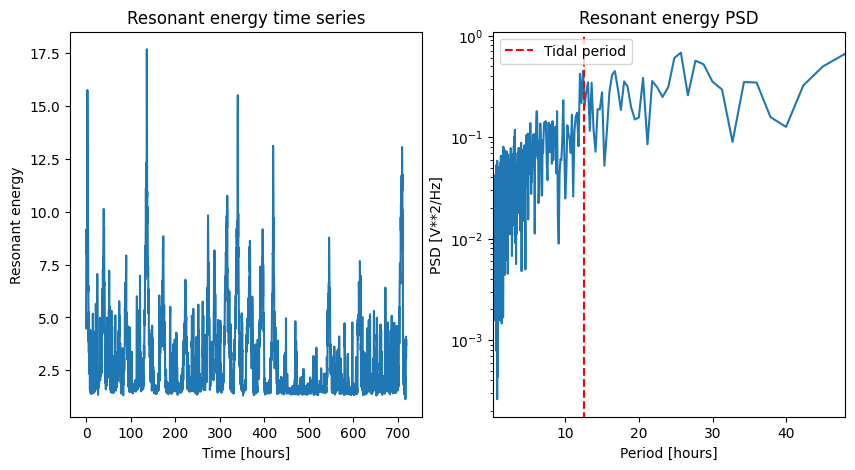

In [13]:
from scipy.fft import fft, fftfreq
resonant_energy_timeseries = np.abs(np.mean(energies, axis=(1,2)))
fs = 1/(15*60)
T = 1/fs
N = len(resonant_energy_timeseries)
yf = fft(resonant_energy_timeseries - np.mean(resonant_energy_timeseries))
xf = fftfreq(N, T)[:N//2]
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].plot(np.array(list(range(len(resonant_energy_timeseries))))/4, resonant_energy_timeseries)
axs[0].set_title('Resonant energy time series')
axs[0].set_xlabel('Time [hours]')
axs[0].set_ylabel('Resonant energy')

ax = axs[1]
ax.semilogy((1/(xf*60*60)), 2.0/N * np.abs(yf[0:N//2]))
ax.set_xlim([0.15, 48])
ax.vlines([12.5], 1e-4, 1, colors='r', linestyles='dashed', label='Tidal period')
ax.legend()
ax.set_title('Resonant energy PSD')
ax.set_xlabel('Period [hours]')
ax.set_ylabel('PSD [V**2/Hz]')
plt.show()

In [36]:
class MeanResonanceScale:

    def __init__(self, image_folder, resonant_energy_folder, average_noise_margin = 3):
        self.image_folder = image_folder
        self.resonant_energy_folder = resonant_energy_folder
        self.average_noise_margin = average_noise_margin
        # self.region_mask = np.repeat(self.create_region_mask()[::-1, np.newaxis], 60, axis=1)
            
    
    def get_resonance_free_pixels(self, resonant_energy_array):
        return resonant_energy_array == 0
    
    def compute_per_freq_energy_sums_and_counts(self, image, noise_pixels):
        non_zero_counts = noise_pixels.sum(axis=1)
        row_sums = (image * noise_pixels).sum(axis=1)
        noise_sums = (image * ~noise_pixels).sum(axis=1)
        zero_counts = (~noise_pixels).sum(axis=1)

        return row_sums, noise_sums, non_zero_counts, zero_counts

    def get_all_per_freq_statistics(self, file):
        
        image =  RawDataDataset.load_image(self.image_folder / file.name, pad=(0,0,0,0)).squeeze()
        resonant_energy_array = load_resonant_energy_array(self.resonant_energy_folder  / file.name)
        noise_pixels = self.get_resonance_free_pixels(resonant_energy_array)        
        energy_data =  self.compute_per_freq_energy_sums_and_counts(image, noise_pixels)
        average_energy = energy_data[0] / energy_data[2]
        average_noise_energy = energy_data[1] / energy_data[3]
        # smoothed_noise = np.convolve(average_noise_energy, np.ones(5), 'same') / 5

        average_strength = average_energy - average_noise_energy
        return average_energy, average_strength

resonance_strength_calculator = MeanResonanceScale(out_dir, Path(resonant_energy_folder))

In [ ]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
files = list((file,) for file in Path(resonant_energy_folder).glob('*.h5'))
energy_data = parallel_execution(files, resonance_strength_calculator.get_all_per_freq_statistics)

In [41]:
freq_resonance_strngths= np.vstack([energy for energy, strength in energy_data])
res_strengths_ts = np.nanmean(freq_resonance_strngths, axis=1)

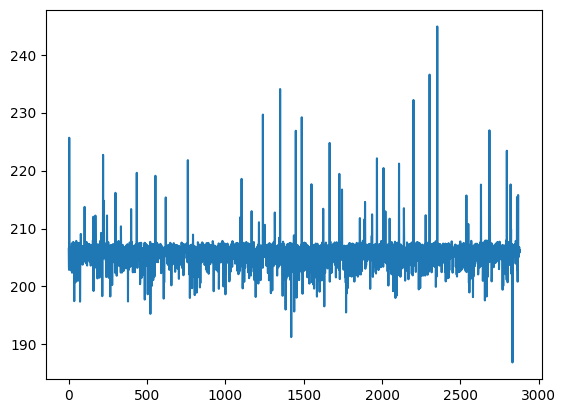

In [42]:
resonant_energy_timeseries = np.abs(res_strengths_ts)[~np.isnan(res_strengths_ts)]
plt.plot(resonant_energy_timeseries)
plt.show()